## Table of Contents:

1. [Problem Definition](#1.-Problem-Definition)
    * [1.a Real-Life Applications](##1.a-Real-Life-Applications)
2. [Understanding the Data and the Challenges](#2.-Understanding-the-Data-and-the-Challenges)
    * [2.a CelebA Dataset](#2.a-CelebA-Dataset)
    * [2.b The Challenges in Getting the Data](#2.b-The-Challenges-in-Getting-the-Data)
3. [Modeling](#3.-Modeling)
    * [3.1 Importing Data](#3.1-Importing-Data)
    * [3.2 Reshaping Data](#3.2-Reshaping-Data)
    * [3.3 3.3 Trying and Exploring Different Models](#3.3-Trying-and-Exploring-Different-Models)
        * [3.3.1 First Model: A Basic Convolutional Encoder-Decoder Network](#3.3.1-First-Model:-A-Basic-Convolutional-Encoder-Decoder-Network)
        * [3.3.2 Applying a Better Model for Semantic Segmentation: SegNet](#3.3.2-Applying-a-Better-Model-for-Semantic-Segmentation:-SegNet)
        * [3.3.3 Implementation of Deep Image Matting](#3.3.3-Implementation-of-Deep-Image-Matting)
    * [3.4 Evaluating the Models](#3.4-Evaluating-the-Models)
4. [Conclusion](#4.-Conclusion)

## 1. Problem Definition
__Image matting__ is the process of extracting the foreground from and image.  
The objective of this work is to extract human portraits from images.  

This project's challenge is the difficulty of keeping low-level detail in a photo like flying hairs.

## 1.a Real-Life Applications

How can image matting be used? Here are some applications which may need image matting:

* Tools the customers enjoy (i.e., Making the background of a photo blurry, imitating the quality of a large-aperture lens)
* pplying a different background in image and video production

## 2. Understanding the Data and the Data Challenges

### 2.a CelebA Dataset

Matting a portrait image is a real challenge because I do not have the target data (matted image). In other words, I do not have input - mask pair images.  
For this work, the dataset in consideration is [CelebA dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains more than 200K celebrity images.

## 2.b The Challenges in Getting the Data

Producing a matted dataset is very costly. The training dataset in this work is produced with GAN. These are the steps to generate GAN images:

  
* Step 1: I calculated the time I spent in removing the background in Photoshop. I found that I can process 200 images in 6 hours.  
* Step 2: I randomly selected 200 images and processed them. Here is one example:

![Matting-Photoshop](images/matting-image-photoshop.png)

**Step 3:** I fed my dataset (200 image pairs) to [pix2pix](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) GAN. After I trained the GAN model, I generated matted images for 203K images.   
**Step 4:** Most of the images had artifacts. Therefore, I manually selected more than 3000 images.

![Matting-Photoshop](images/celeba-matting.png)

This process is not in the scope of this work, therefore, I won't put codes here. I will write a separate blog post.

# 3. Modeling
In this part, I will start with a simple convolutional encoder-decoder network. Then, I will use a better network for semantic segmentation (SegNet). Finally, I will try the Deep Image Matting solution.  

In [1]:
# system
import os

# image, matrix processing
import numpy as np
from PIL import Image

# deep learning
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# layers
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate, Input

# models
from tensorflow.keras.models import Model
from tensorflow.keras import Model

from tensorflow.keras import backend as K

Allowing GPU:

In [2]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
tf.test.is_gpu_available()

True

## 3.1 Importing Data

The data are structured on the disk as follows:

    data
    ├── testing
    │   ├── A
    │   │   ├── 150496.png
    │   │   ├── 057190.png
    │   │   ├── ...
    │   │   └── ...
    │   └── B
    │       ├── 076091.png
    │       ├── 083990.png
    │       ├── ...  
    │       └── ...
    ├── training
    │   ├── A
    │   │   ├── 127444.png
    │   │   ├── 058770.png
    │   │   ├── ...
    │   │   └── ...
    │   └── B
    │       ├── 055621.png
    │       ├── 068465.png
    │       ├── ...
    │       └── ...
    └── validation
        ├── A
        │   ├── 065456.png
        │   ├── 085476.png
        │   ├── ...        
        │   └── ...
        └── B
            ├── 078963.png
            ├── 124666.png
            ├── ...            
            └── ...
            
The following code chunks are importing images and storing in `numpy` arrays.  

In [3]:
data_dir = '/media/imran/SSD/celeba/data'

training_a = os.path.join(data_dir, 'training/A')
training_b = os.path.join(data_dir, 'training/B')
training_images_a = os.listdir(training_a)
training_images_b = os.listdir(training_b)

testing_a = os.path.join(data_dir, 'testing/A')
testing_images_a = os.listdir(testing_a)

validation_a = os.path.join(data_dir, 'validation/A')
validation_b = os.path.join(data_dir, 'validation/B')
validation_images_a = os.listdir(validation_a)
validation_images_b = os.listdir(validation_b)

To computational efficiency, I resized the images into 64x64 pixels.  

In [4]:
img_dim_pixel = 64 # 64x64 pixel in size

In [5]:
# Training A: CelebA samples
training_a = np.zeros((len(training_images_a), img_dim_pixel, img_dim_pixel, 3)) # placeholder
loop_counter = 0
for i in training_images_a:
    img_path = os.path.join(data_dir, 'training/A', i)
    img = Image.open(img_path).resize((img_dim_pixel, img_dim_pixel))
    img = img.convert('RGB')
    img_np = np.array(img)
    training_a[loop_counter] = img_np
    loop_counter +=1
    
# Training B: CelebA maskings
training_b = np.zeros((len(training_images_b), img_dim_pixel, img_dim_pixel, 3)) # placeholder
loop_counter = 0
for i in training_images_b:
    img_path = os.path.join(data_dir, 'training/B', i)
    img = Image.open(img_path).resize((img_dim_pixel, img_dim_pixel))
    img_np = np.array(img)
    training_b[loop_counter] = img_np
    loop_counter +=1

In [6]:
# Validation A: CelebA samples
validation_a = np.zeros((len(validation_images_a), img_dim_pixel, img_dim_pixel, 3)) # placeholder
loop_counter = 0
for i in validation_images_a:
    img_path = os.path.join(data_dir, 'validation/A', i)
    img = Image.open(img_path).resize((img_dim_pixel, img_dim_pixel))
    img_np = np.array(img)
    validation_a[loop_counter] = img_np
    loop_counter +=1
    
# Validation B: CelebA maskings
validation_b = np.zeros((len(validation_images_b), img_dim_pixel, img_dim_pixel, 3)) # placeholder
loop_counter = 0
for i in validation_images_b:
    img_path = os.path.join(data_dir, 'validation/B', i)
    img = Image.open(img_path).resize((img_dim_pixel, img_dim_pixel))
    img_np = np.array(img)
    validation_b[loop_counter] = img_np
    loop_counter +=1

In [7]:
# Testing A: CelebA samples
testing_a = np.zeros((len(testing_images_a), img_dim_pixel, img_dim_pixel, 3)) # placeholder
loop_counter = 0
for i in testing_images_a:
    img_path = os.path.join(data_dir, 'testing/A', i)
    img = Image.open(img_path).resize((img_dim_pixel, img_dim_pixel))
    img_np = np.array(img)
    testing_a[loop_counter] = img_np
    loop_counter +=1

## 3.2 Reshaping Data

In [8]:
# scaling pixel values: for avoiding exploding values
training_a = training_a/255.
training_b = training_b/255.
validation_a = validation_a/255.
validation_b = validation_b/255.
testing_a = testing_a/255.

training_a   = np.reshape(training_a, (len(training_a), img_dim_pixel, img_dim_pixel, 3))
training_b   = np.reshape(training_b, (len(training_b), img_dim_pixel, img_dim_pixel, 3))
validation_a = np.reshape(validation_a, (len(validation_a), img_dim_pixel, img_dim_pixel, 3))
validation_b = np.reshape(validation_b, (len(validation_b), img_dim_pixel, img_dim_pixel, 3))
testing_a    = np.reshape(testing_a, (len(testing_a), img_dim_pixel, img_dim_pixel, 3))

## 3.3 Trying and Exploring Different Models
### 3.3.1 First Model: A Basic Convolutional Encoder-Decoder Network

Starting with a relatively simple encoder-decoder model.  
Better to understand this model because the next model will be based on a similar idea.  

Simple explanation:  
- It is like a butterfly shaped network which contains two components: encoder, decoder.  
- The __encoder__ compresses data, it extract core features of the input. It is stored in the latent space.  
- The __decoder__ reconstructs an image by taking the latent space as input.  

![autoencoder](https://upload.wikimedia.org/wikipedia/commons/3/37/Autoencoder_schema.png)

Illustraion: By Michela Massi - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=80177333

#### 3.3.1.1 Building the Model

In [15]:
input_img = Input(shape=(64, 64, 3)) 

# encoder 
x = Conv2D(48, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(32, (1, 1), activation='relu', padding='same')(x)

# latent space
latent_dim = (8,8,32)

# decoder
direct_input = Input(shape=latent_dim)
x = Conv2D(192, (1, 1), activation='relu', padding='same')(direct_input)
x = UpSampling2D((2, 2))(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# model
encoder = Model(input_img, encoded)
decoder = Model(direct_input, decoded)
conv_encoder_decoder = Model(input_img, decoder(encoded))

#### 3.3.1.2 Compiling the Model

In [16]:
# compiling the model
conv_encoder_decoder.compile(optimizer='Adam', loss='binary_crossentropy')

#### 3.3.1.3 Training the Model

In [19]:
conv_encoder_decoder.fit(training_a, training_b,
                         epochs=40,
                         batch_size=64,
                         shuffle=True,
                         validation_data = (validation_a, validation_b),
                         verbose = 1)

Train on 3255 samples, validate on 100 samples
Epoch 1/40
3255/3255 [==============================] - 6s 2ms/sample - loss: 0.4039 - val_loss: 0.1967
Epoch 2/40
3255/3255 [==============================] - 2s 611us/sample - loss: 0.1916 - val_loss: 0.1378
Epoch 3/40
3255/3255 [==============================] - 2s 614us/sample - loss: 0.1580 - val_loss: 0.1247
Epoch 4/40
3255/3255 [==============================] - 2s 642us/sample - loss: 0.1402 - val_loss: 0.1157
Epoch 5/40
3255/3255 [==============================] - 2s 681us/sample - loss: 0.1354 - val_loss: 0.1162
Epoch 6/40
3255/3255 [==============================] - 2s 633us/sample - loss: 0.1243 - val_loss: 0.1059
Epoch 7/40
3255/3255 [==============================] - 2s 606us/sample - loss: 0.1201 - val_loss: 0.1062
Epoch 8/40
3255/3255 [==============================] - 2s 611us/sample - loss: 0.1181 - val_loss: 0.1096
Epoch 9/40
3255/3255 [==============================] - 2s 662us/sample - loss: 0.1128 - val_loss: 0.1074
E

#### 3.3.1.4 Visualizing the Predictions

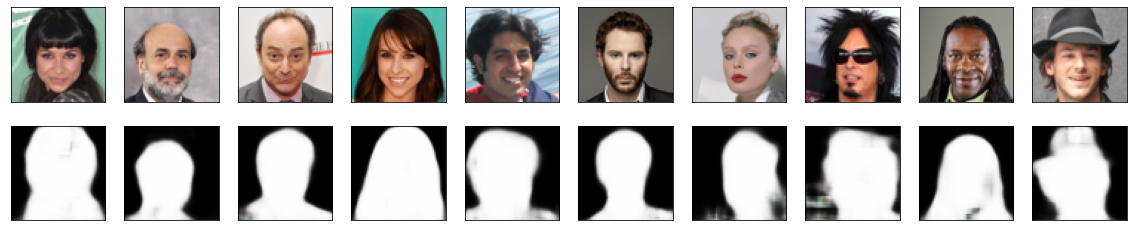

In [20]:
decoded_imgs = conv_encoder_decoder.predict(testing_a)

import matplotlib.pyplot as plt

n = 10  # number of samples
img_index = 0

plt.figure(figsize=(20, 4))
for i in range(n):
    
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(testing_a[img_index+i].reshape(img_dim_pixel, img_dim_pixel,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[img_index+i].reshape(img_dim_pixel, img_dim_pixel,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [21]:
conv_encoder_decoder.save('conv_autoencoder.h5')

The results are not visually appealing, but we wouldn not expect more with a simple model.

### 3.3.2 Applying a Better Model for Semantic Segmentation: SegNet
[SeGNet](https://mi.eng.cam.ac.uk/projects/segnet/) has been developed by Alex Kendall, Vijay Badrinarayanan, Roberto Cipolla, and it is a useful model for pixel-wise segmentation.
It is also an encoder-decoder network, but more sophisticated than the above.  

![SegNet](https://mi.eng.cam.ac.uk/projects/segnet/images/segnet.png)

I will start with this on then, apply the refinement solution on top of this model.  

I copied model definition code from [Deep-Image-Matting](https://github.com/foamliu/Deep-Image-Matting/blob/master/segnet.py) GitHub repo.

In [9]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Lambda, Multiply

class Unpooling(Layer):

    def __init__(self, **kwargs):
        super(Unpooling, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Unpooling, self).build(input_shape)

    def call(self, inputs, **kwargs):
        x = inputs[:, 1]
        bool_mask = Lambda(lambda t: K.greater_equal(t[:, 0], t[:, 1]),
                           output_shape=K.int_shape(x)[1:])(inputs)
        mask = Lambda(lambda t: K.cast(t, dtype='float32'))(bool_mask)
        x = Multiply()([mask, x])
        return x

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2], input_shape[3], input_shape[4]

In [10]:
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, ZeroPadding2D, MaxPooling2D, Reshape, Concatenate, Lambda

kernel = 3

# Encoder
#
input_tensor = Input(shape=(64, 64, 3))
x = ZeroPadding2D((1, 1))(input_tensor)
x = Conv2D(64, (kernel, kernel), activation='relu', name='conv1_1')(x)
x = ZeroPadding2D((1, 1))(x)
x = Conv2D(64, (kernel, kernel), activation='relu', name='conv1_2')(x)
orig_1 = x
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

x = ZeroPadding2D((1, 1))(x)
x = Conv2D(128, (kernel, kernel), activation='relu', name='conv2_1')(x)
x = ZeroPadding2D((1, 1))(x)
x = Conv2D(128, (kernel, kernel), activation='relu', name='conv2_2')(x)
orig_2 = x
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

x = ZeroPadding2D((1, 1))(x)
x = Conv2D(256, (kernel, kernel), activation='relu', name='conv3_1')(x)
x = ZeroPadding2D((1, 1))(x)
x = Conv2D(256, (kernel, kernel), activation='relu', name='conv3_2')(x)
x = ZeroPadding2D((1, 1))(x)
x = Conv2D(256, (kernel, kernel), activation='relu', name='conv3_3')(x)
orig_3 = x
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

x = ZeroPadding2D((1, 1))(x)
x = Conv2D(512, (kernel, kernel), activation='relu', name='conv4_1')(x)
x = ZeroPadding2D((1, 1))(x)
x = Conv2D(512, (kernel, kernel), activation='relu', name='conv4_2')(x)
x = ZeroPadding2D((1, 1))(x)
x = Conv2D(512, (kernel, kernel), activation='relu', name='conv4_3')(x)
orig_4 = x
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

x = ZeroPadding2D((1, 1))(x)
x = Conv2D(512, (kernel, kernel), activation='relu', name='conv5_1')(x)
x = ZeroPadding2D((1, 1))(x)
x = Conv2D(512, (kernel, kernel), activation='relu', name='conv5_2')(x)
x = ZeroPadding2D((1, 1))(x)
x = Conv2D(512, (kernel, kernel), activation='relu', name='conv5_3')(x)
orig_5 = x
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

# Decoder
#
x = UpSampling2D(size=(2, 2))(x)
the_shape = K.int_shape(orig_5)
shape = (1, the_shape[1], the_shape[2], the_shape[3])
origReshaped = Reshape(shape)(orig_5)
xReshaped = Reshape(shape)(x)
together = Concatenate(axis=1)([origReshaped, xReshaped])
x = Unpooling()(together)
x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', name='deconv5_1',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', name='deconv5_2',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', name='deconv5_3',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)

x = UpSampling2D(size=(2, 2))(x)
the_shape = K.int_shape(orig_4)
shape = (1, the_shape[1], the_shape[2], the_shape[3])
origReshaped = Reshape(shape)(orig_4)
xReshaped = Reshape(shape)(x)
together = Concatenate(axis=1)([origReshaped, xReshaped])
x = Unpooling()(together)
x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='deconv4_1',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='deconv4_2',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='deconv4_3',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)

x = UpSampling2D(size=(2, 2))(x)
the_shape = K.int_shape(orig_3)
shape = (1, the_shape[1], the_shape[2], the_shape[3])
origReshaped = Reshape(shape)(orig_3)
xReshaped = Reshape(shape)(x)
together = Concatenate(axis=1)([origReshaped, xReshaped])
x = Unpooling()(together)
x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='deconv3_1',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='deconv3_2',
       kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='deconv3_3',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)

x = UpSampling2D(size=(2, 2))(x)
the_shape = K.int_shape(orig_2)
shape = (1, the_shape[1], the_shape[2], the_shape[3])
origReshaped = Reshape(shape)(orig_2)
xReshaped = Reshape(shape)(x)
together = Concatenate(axis=1)([origReshaped, xReshaped])
x = Unpooling()(together)
x = Conv2D(64, (kernel, kernel), activation='relu', padding='same', name='deconv2_1',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (kernel, kernel), activation='relu', padding='same', name='deconv2_2',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)

x = UpSampling2D(size=(2, 2))(x)
the_shape = K.int_shape(orig_1)
shape = (1, the_shape[1], the_shape[2], the_shape[3])
origReshaped = Reshape(shape)(orig_1)
xReshaped = Reshape(shape)(x)
together = Concatenate(axis=1)([origReshaped, xReshaped])
x = Unpooling()(together)
x = Conv2D(64, (kernel, kernel), activation='relu', padding='same', name='deconv1_1',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (kernel, kernel), activation='relu', padding='same', name='deconv1_2',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)

x = Conv2D(1, (kernel, kernel), activation='sigmoid', padding='same', name='pred', kernel_initializer='he_normal',
           bias_initializer='zeros')(x)

segnet = Model(inputs=input_tensor, outputs=x)

Defining Losses for SegNet: 

In [11]:
img_rows, img_cols = 64, 64
epsilon = 1e-6
epsilon_sqr = epsilon ** 2

def overall_loss(y_true, y_pred):
    w_l = 0.5
    return w_l * alpha_prediction_loss(y_true, y_pred) + (1 - w_l) * compositional_loss(y_true, y_pred)

def alpha_prediction_loss(y_true, y_pred):
    mask = y_true[:, :, :, 1]
    diff = y_pred[:, :, :, 0] - y_true[:, :, :, 0]
    diff = diff * mask
    num_pixels = K.sum(mask)
    return K.sum(K.sqrt(K.square(diff) + epsilon_sqr)) / (num_pixels + epsilon)

def compositional_loss(y_true, y_pred):
    mask = y_true[:, :, :, 1]
    mask = K.reshape(mask, (-1, img_rows, img_cols, 1))
    image = y_true[:, :, :, 2:5]
    fg = y_true[:, :, :, 5:8]
    bg = y_true[:, :, :, 8:11]
    c_g = image
    c_p = y_pred * fg + (1.0 - y_pred) * bg
    diff = c_p - c_g
    diff = diff * mask
    num_pixels = K.sum(mask)
    return K.sum(K.sqrt(K.square(diff) + epsilon_sqr)) / (num_pixels + epsilon)

In [12]:
segnet.compile(optimizer='nadam', loss=overall_loss)

Training SegNet:

In [29]:
segnet.fit(training_a, training_b,
                         epochs=40,
                         batch_size=64,
                         shuffle=True,
                         validation_data = (validation_a, validation_b),
                         verbose = 1)

In [36]:
segnet.save('segnet.h5')

In [37]:
decoded_imgs = segnet.predict(testing_a)

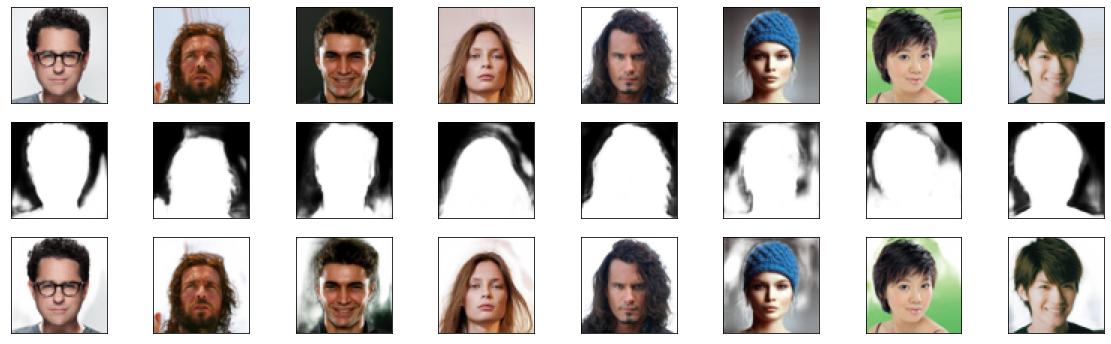

In [38]:
import matplotlib.pyplot as plt

n = 8  # number of samples
img_index = 10

plt.figure(figsize=(20, 6))
for i in range(n):
    
    # original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(testing_a[img_index+i].reshape(img_dim_pixel, img_dim_pixel,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # mask
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[img_index+i].reshape(img_dim_pixel, img_dim_pixel))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # matting
    ax = plt.subplot(3, n, i + n + n+ 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    img = testing_a[img_index+i].reshape(img_dim_pixel, img_dim_pixel,3)
    mask = decoded_imgs[img_index+i].reshape(img_dim_pixel, img_dim_pixel)
    red, green, blue = img.T
    red=red**mask.T
    green=green**mask.T
    blue = blue**mask.T
    matted = np.array((red,green,blue)).T
    plt.imshow(matted)
    
plt.show()

### 3.3.3 Implementation of Deep Image Matting

Previous two models were keeping the high-level details like head and its rotation. However, the low-level details like flying hairs are not preserved.  
A perfect solution to this problem is proposed in [Deep Image Matting](https://arxiv.org/pdf/1703.03872.pdf) paper by Ning Xu, Brian Price, Scott Cohen, and Thomas Huang.  
This network is also an encoder-decoder network, but it refines the output by applying a refinement.

![SegNet](images/deep-image-matting.png)

Illustration: Taken from the [Deep Image Matting](https://arxiv.org/pdf/1703.03872.pdf) paper.

In [12]:
encoder_decoder = segnet # using the existing model
input_tensor = encoder_decoder.input

input = Lambda(lambda i: i[:, :, :, 0:3])(input_tensor)

x = Concatenate(axis=3)([input, encoder_decoder.output])
x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='refinement_pred', kernel_initializer='he_normal',
           bias_initializer='zeros')(x)

model_matting = Model(inputs=input_tensor, outputs=x)

Compiling the Model:

In [13]:
decoder_target = tf.keras.backend.placeholder(dtype='float32', shape=(None, None, None, None))
model_matting.compile(optimizer='nadam', loss=overall_loss, target_tensors=[decoder_target])

In [30]:
model_matting.fit(training_a, training_b,
                  epochs=40,
                  verbose=1,
                  batch_size=64
                 )

Train on 3255 samples
Epoch 1/40
3255/3255 [==============================] - 9s 3ms/sample - loss: 0.0044
Epoch 2/40
3255/3255 [==============================] - 9s 3ms/sample - loss: 0.0043
Epoch 3/40
3255/3255 [==============================] - 9s 3ms/sample - loss: 0.0043
Epoch 4/40
3255/3255 [==============================] - 10s 3ms/sample - loss: 0.0043
Epoch 5/40
3255/3255 [==============================] - 9s 3ms/sample - loss: 0.0043
Epoch 6/40
3255/3255 [==============================] - 9s 3ms/sample - loss: 0.0044
Epoch 7/40
3255/3255 [==============================] - 9s 3ms/sample - loss: 0.0043
Epoch 8/40
3255/3255 [==============================] - 9s 3ms/sample - loss: 0.0042
Epoch 9/40
3255/3255 [==============================] - 9s 3ms/sample - loss: 0.0042
Epoch 10/40
3255/3255 [==============================] - 9s 3ms/sample - loss: 0.0042
Epoch 11/40
3255/3255 [==============================] - 9s 3ms/sample - loss: 0.0043
Epoch 12/40
3255/3255 [=================

In [29]:
model_matting.save('model_matting.h5')

In [27]:
decoded_imgs = model_matting.predict(testing_a)

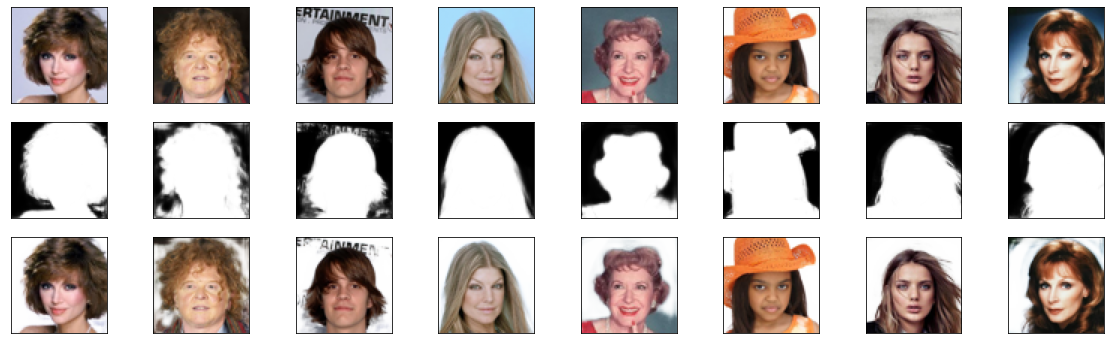

In [40]:
import matplotlib.pyplot as plt

n = 8  # number of samples
img_index = 31

plt.figure(figsize=(20, 6))
for i in range(n):
    
    # original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(testing_a[img_index+i].reshape(img_dim_pixel, img_dim_pixel,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # mask
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[img_index+i].reshape(img_dim_pixel, img_dim_pixel))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # matting
    ax = plt.subplot(3, n, i + n + n+ 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    img = testing_a[img_index+i].reshape(img_dim_pixel, img_dim_pixel,3)
    mask = decoded_imgs[img_index+i].reshape(img_dim_pixel, img_dim_pixel)
    red, green, blue = img.T
    red=red**mask.T
    green=green**mask.T
    blue = blue**mask.T
    matted = np.array((red,green,blue)).T
    plt.imshow(matted)
    
plt.show()

## 3.4 Evaluating the Models
* We are losing data with an encoder-decoder network because the features in the image are encoded in the latent space.  
* SegNet is one of the best models, and it would work for images with no low-level detail like car photos. However, we are losing low-level features in human portrait photo matting. Therefore, we need refinement.  
* Deep Image Matting solution is working well because low-level features are being preserved.

# 4. Conclusion
For this project, it was very costly to get training data. Therefore, I generated mask images with GAN. The quality of the images is not very good, and it affected the final performance. However, it was sufficient for implementing those three models and seeing the results.